In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [132]:
#lib for utilities
import warnings
from pathlib import Path

#lib for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

#lib for math
import numpy as np

#lib for data handling
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=14,
    titlepad=10
)

warnings.filterwarnings("ignore")

In [133]:
def load_data():
    # Read data
    data_path = Path("../input/titanic/")
    df_train = pd.read_csv(data_path / "train.csv", index_col="PassengerId")
    df_test = pd.read_csv(data_path / "test.csv", index_col="PassengerId")
    
    # Save indexes
    train_index = df_train.index
    test_index = df_test.index

    # Merge full dataset
    df_full = pd.concat([df_train, df_test])
    
    # Preprocess all the data
    df_full = clean(df_full)
    df_full = impute(df_full, train_index, test_index)
    df_full = encode(df_full, train_index, test_index)

    # Redistribute all the data
    df_train = df_full.loc[train_index]
    df_test = df_full.loc[test_index]

    # Return treated data
    return df_train, df_test

In [134]:
def load_data():
    # Read data
    data_path = Path("../input/titanic/")
    df_train = pd.read_csv(data_path / "train.csv", index_col="PassengerId")
    df_test = pd.read_csv(data_path / "test.csv", index_col="PassengerId")
    
    # Save indexes
    train_index = df_train.index
    test_index = df_test.index

    # Merge full dataset
    df_full = pd.concat([df_train, df_test])
    
    # Preprocess all the data
    df_full = clean(df_full)
    df_full = impute(df_full, train_index, test_index)
    df_full = encode(df_full, train_index, test_index)

    # Redistribute all the data
    df_train = df_full.loc[train_index]
    df_test = df_full.loc[test_index]

    # Return treated data
    return df_train, df_test

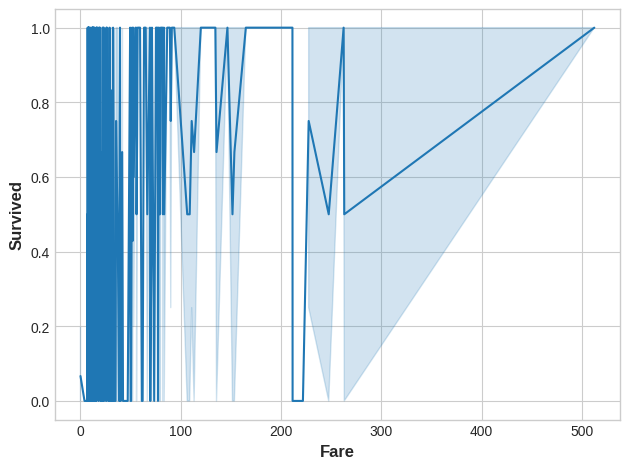

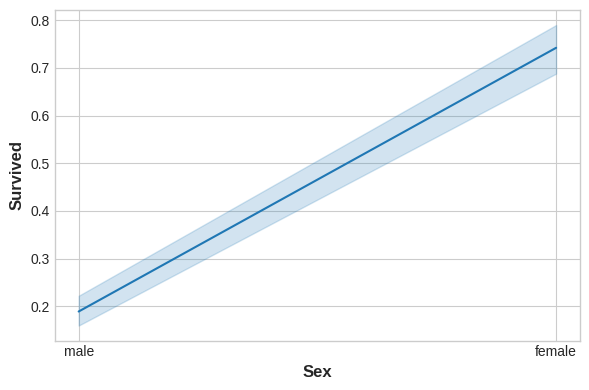

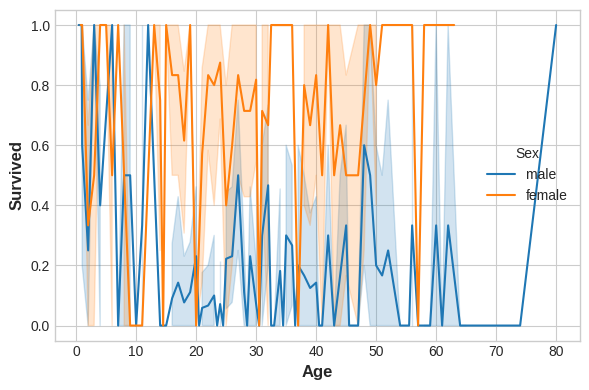

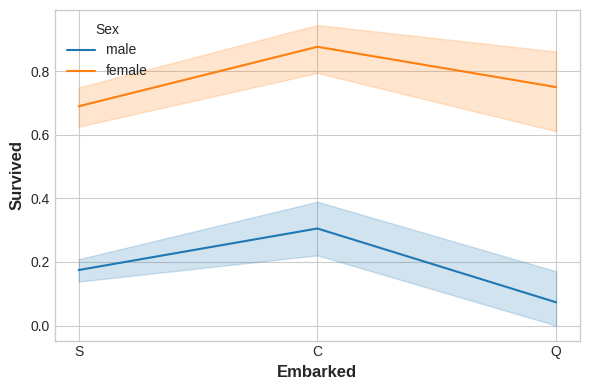

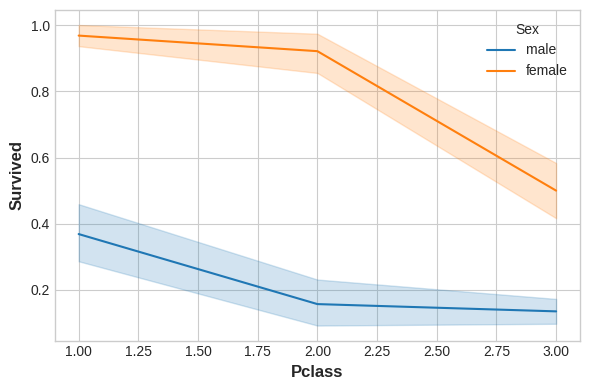

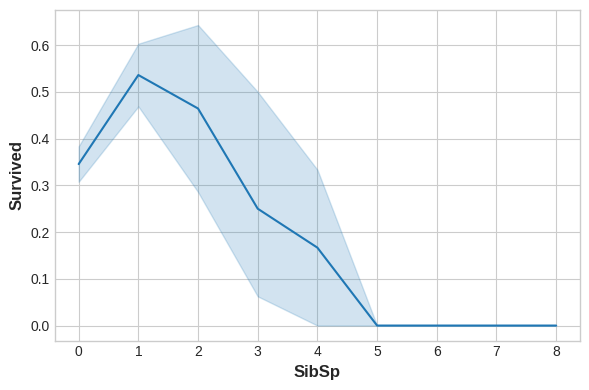

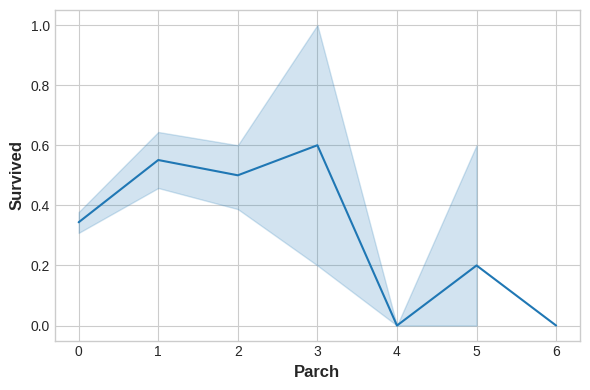

In [135]:
def graphical_hypothesis():
    data_path = Path("../input/titanic/")
    df_train = pd.read_csv(data_path / "train.csv", index_col="PassengerId")
    sns.lineplot(data=df_train, x="Fare", y="Survived")
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_train, x="Sex", y="Survived")
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_train, x="Age", y="Survived", hue="Sex")
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_train, x="Embarked", y="Survived", hue="Sex")
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_train, x="Pclass", y="Survived", hue="Sex")
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_train, x="SibSp", y="Survived")
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_train, x="Parch", y="Survived")
graphical_hypothesis()

In [136]:
def compute_title(title):
    if title in ["Mr", "Miss", "Mrs", "Master"]:
        return title
    else:
        return "Rare"

def compute_pont(pont):
    if pont in ["C", "B", "D", "A"]:
        return "luxury"
    else:
        return "economy"

def compute_ticket_prefix(ticket):
    parts = ticket.replace('.', '').replace('/', '').split(' ')
    if len(parts) > 0 and not parts[0].isdigit():
        return parts[0]
    else:
        return "None"

def clean(df):
    # Extract the person's title from the name, as this data often reflects social status.
    df["Title"] = df["Name"].str.extract(r',\s*([^\.]+)\.')
    df["Title"] = df["Title"].apply(compute_title)

    # Extract the person's family name, as it can be used to enable groupings (feature engineering).
    df["Name"] = df["Name"].str.split(',').str[0]

    # Extract the cabin deck (first letter of the cabin), as some decks were closer to lifeboats.
    df["Pont"] = df["Cabin"].str[0]
    df["Pont"] = df["Pont"].apply(compute_pont)

    # Extract ticket prefix
    df["Ticket"] = df["Ticket"].apply(compute_ticket_prefix)
    
    # Group rare ticket under "other" denomination
    ticket_occurence = df.Ticket.value_counts()
    rare_ticket = ticket_occurence[ticket_occurence < 10].index
    df["Ticket"] = df["Ticket"].apply(lambda x: "Other" if x in rare_ticket else x)

    # Drop unnecessary columns
    df = df.drop(columns=["Cabin"])
    return df

In [137]:
nominal_features = ["Name", "Sex", "Ticket", "Pont"]
one_hot_features = ["Embarked"]
title_levels = ["None", "Mr", "Rare", "Master", "Miss", "Mrs"]
ordinal_levels = {
    "Title": title_levels
}

def encode(df, train_indexes, test_indexes):
    # Encode nominal categories
    for feature in nominal_features:
        df[feature] = df[feature].astype("category")
        if "None" not in df[feature].cat.categories:
            df[feature] = df[feature].cat.add_categories("None")

    # Encode ordinal categories
    for feature, levels in ordinal_levels.items():
        df[feature] = df[feature].astype(CategoricalDtype(levels, ordered=True))

    # Declare One hot encoder class
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

    # Avoid data leakage
    df_train = df.loc[train_indexes].copy()
    df_test = df.loc[test_indexes].copy()

    # Encode one hot categories
    for feature in one_hot_features:
        df_train_encoded = OH_encoder.fit_transform(df_train[[feature]])
        df_test_encoded = OH_encoder.transform(df_test[[feature]])

        # Rename columns
        cols_names = [f"{feature}_{cat}" for cat in OH_encoder.categories_[0]]

        # Assign the columns to the encoded dataframe
        df_train_encoded = pd.DataFrame(df_train_encoded, columns=cols_names, index=df_train.index)
        df_test_encoded = pd.DataFrame(df_test_encoded, columns=cols_names, index=df_test.index)

        df_train = pd.concat([df_train.drop(columns=[feature]), df_train_encoded], axis=1)
        df_test = pd.concat([df_test.drop(columns=[feature]), df_test_encoded], axis=1)
    df = pd.concat([df_train, df_test]).sort_index()
    return df

In [138]:
def impute(df, train_index, test_index):
    # List each type of feature
    numerical_feature = ["Age", "Fare"]
    categorical_feature = {
        "Embarked": "C"
    }

    # Seperate the dataset
    df_train = df.loc[train_index].copy()
    df_test = df.loc[test_index].copy()
    
    # Init simple imputer class (Median strategy will be done for numerical features)
    median_imputer = SimpleImputer(strategy="median")
    for feature in numerical_feature:
        df_train[feature] = median_imputer.fit_transform(df_train[[feature]])
        df_test[feature] = median_imputer.transform(df_test[[feature]])

    # Init simple imputer class (Constant strategy will be done for categorical features)
    for feature, constant in categorical_feature.items():
        constant_imputer = SimpleImputer(strategy="constant", fill_value=constant)
        df_train[feature] = constant_imputer.fit_transform(df_train[[feature]]).ravel()
        df_test[feature] = constant_imputer.transform(df_test[[feature]]).ravel()

    # Retrive the data set
    df = pd.concat([df_train, df_test]).sort_index()
    return df

In [139]:
df_train, df_test = load_data()
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    float64 
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    category
 3   Sex         891 non-null    category
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Ticket      891 non-null    category
 8   Fare        891 non-null    float64 
 9   Title       891 non-null    category
 10  Pont        891 non-null    category
 11  Embarked_C  891 non-null    float64 
 12  Embarked_Q  891 non-null    float64 
 13  Embarked_S  891 non-null    float64 
dtypes: category(5), float64(6), int64(3)
memory usage: 114.8 KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Title,Pont,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,
1,0.0,3,Braund,male,22.0,1,0,A5,7.2500,Mr,economy,0.0,0.0,1.0
2,1.0,1,Cumings,female,38.0,1,0,PC,71.2833,Mrs,luxury,1.0,0.0,0.0
3,1.0,3,Heikkinen,female,26.0,0,0,Other,7.9250,Miss,economy,0.0,0.0,1.0
4,1.0,1,Futrelle,female,35.0,1,0,None,53.1000,Mrs,luxury,0.0,0.0,1.0
5,0.0,3,Allen,male,35.0,0,0,None,8.0500,Mr,economy,0.0,0.0,1.0


In [140]:
def score_dataset(X_org, y, model=XGBClassifier()):
    X = X_org.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    score = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    score = score.mean()
    return score

In [141]:
X = df_train.copy()
y = X.pop("Survived")
print(df_train["Survived"].isnull().sum())  # ça doit afficher 0
baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

0
Baseline score: 0.80692 RMSLE
